In [395]:
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import copy
from utils import xywhRead, xywh2xyxy, xyxy2xywh

In [240]:
annotfiles = glob.glob('data/labels/*.txt')
np.random.shuffle(annotfiles)

In [357]:
# # check if all images have the same dimensions

# w = 8688
# h = 5792

# imglist = glob.glob('data/*.JPG')
# count = 0
# for im in imglist:
#     print(im)
#     im = Image.open(im)
#     ww, hh = im.size
#     if hh != h or ww != w:
#         print(im, 'this one!')
#     count += 1
# print(count)

data/1V1A9671.JPG
data/1V1A8869.JPG
data/1X7A0933.JPG
data/1V1A9006.JPG
data/1V1A8981.JPG
data/1X7A0862.JPG
data/1V1A9529.JPG
data/1X7A0869.JPG
data/2V3A6814.JPG
data/1V1A9015.JPG
data/2V3A6796.JPG
data/1V1A8946.JPG
data/1X7A0852.JPG
data/1V1A8934.JPG
data/1V1A8834.JPG
data/1V1A8927.JPG
data/1V1A8852.JPG
data/2V3A7130.JPG
data/1V1A8796.JPG
data/1V1A9700.JPG
data/1V1A9051.JPG
data/1X7A0964.JPG
data/1V1A8794.JPG
data/1V1A9205.JPG
data/1V1A8930.JPG
data/2V3A2853.JPG
data/2V3A7160.JPG
data/1V1A8777.JPG
data/1V1A9216.JPG
data/1V1A9281.JPG
data/1V1A8880.JPG
data/2V3A6817.JPG
data/1V1A9269.JPG
data/1X7A0810.JPG
data/2V3A6904.JPG
data/2V3A2562.JPG
data/1V1A9178.JPG
data/1V1A8762.JPG
data/1V1A8942.JPG
data/1V1A9192.JPG
data/1V1A8826.JPG
data/1V1A8875.JPG
data/1V1A8829.JPG
data/1X7A0955.JPG
data/1V1A9228.JPG
data/1X7A0859.JPG
data/1V1A9240.JPG
data/2V3A7014.JPG
data/1X7A0891.JPG
data/2V3A6804.JPG
data/1V1A9333.JPG
data/1V1A9243.JPG
data/1V1A8743.JPG
data/1V1A8963.JPG
data/1V1A8870.JPG
data/2V3A6

In [448]:
imnum = 1
w = 8688
h = 5792

for path2txt in annotfiles:
    
    path2img = os.path.join('data', path2txt.split('/')[-1].split('.')[0]) + '.JPG'

    annotations = np.loadtxt(path2txt)
    cropBoxes = annotations[:,0] == 1  # cropping Boxes are assigned to 1

    xyxy = xywh2xyxy(annotations[:, 1::])  # drop class ids

    # converting to pixel coordinates
    xyxy[:, [0, 2]] = xyxy[:, [0, 2]] * w
    xyxy[:, [1, 3]] = xyxy[:, [1, 3]] * h
    xyxy = xyxy.round().astype(int).squeeze()

    bigBox = copy.copy(xyxy[cropBoxes])
    bboxes = copy.copy(xyxy[~cropBoxes])

    xmin, ymin = bboxes[:,0], bboxes[:,1]
    xmax, ymax = bboxes[:,2], bboxes[:,3]

    for big in bigBox:
        
        x1, y1 = big[0], big[1]
        x2, y2 = big[2], big[3]

        img = cv2.imread(path2img)
        
        # keep objects inside cropBox
        leftBool = xmin >= x1
        rightBool = xmax <= x2
        topBool = ymin >= y1
        botBool = ymax <= y2
        
        new_xyxy = copy.deepcopy(np.array([leftBool, topBool, rightBool, botBool]))
        new_xyxy = bboxes[new_xyxy.all(axis=0)]
        new_xyxy[:, 0] -= x1
        new_xyxy[:, 2] -= x1
        new_xyxy[:, 1] -= y1
        new_xyxy[:, 3] -= y1

        imgCrop = copy.deepcopy(img)[y1:y2, x1:x2, :]
        ww, hh = imgCrop.shape[:-1]
        if ww != 1024 or hh != 1024:
            print(f"{os.path.basename(path2txt)} - crop box is not square")
            print(f"{ww, hh}: width, height")
            continue

        new_xywh = xyxy2xywh(copy.deepcopy(new_xyxy)).astype(np.float32)
        new_xywh[:,0] = new_xywh[:,0] / ww
        new_xywh[:,2] = new_xywh[:,2] / ww
        new_xywh[:,1] = new_xywh[:,1] / hh
        new_xywh[:,3] = new_xywh[:,3] / hh

        new_annotations = np.hstack([np.zeros_like(new_xywh)[:,0].reshape(-1, 1), new_xywh])
        new_annotations = new_annotations.astype(np.float32)


        fmt = '%d', '%1.6f', '%1.6f', '%1.6f', '%1.6f'
        np.savetxt(os.path.join('data/cropped/labels', f"IMG{imnum:04d}" + '.txt'), new_annotations, fmt=fmt)
        cv2.imwrite(os.path.join('data/cropped/', f"IMG{imnum:04d}" + '.jpg'), imgCrop)
        
        imnum += 1   


2V3A6878.txt - crop box is not square
(1025, 1024): width, height
1X7A0891.txt - crop box is not square
(1024, 1025): width, height
2V3A7033.txt - crop box is not square
(1025, 1024): width, height
1V1A9396.txt - crop box is not square
(1025, 1024): width, height


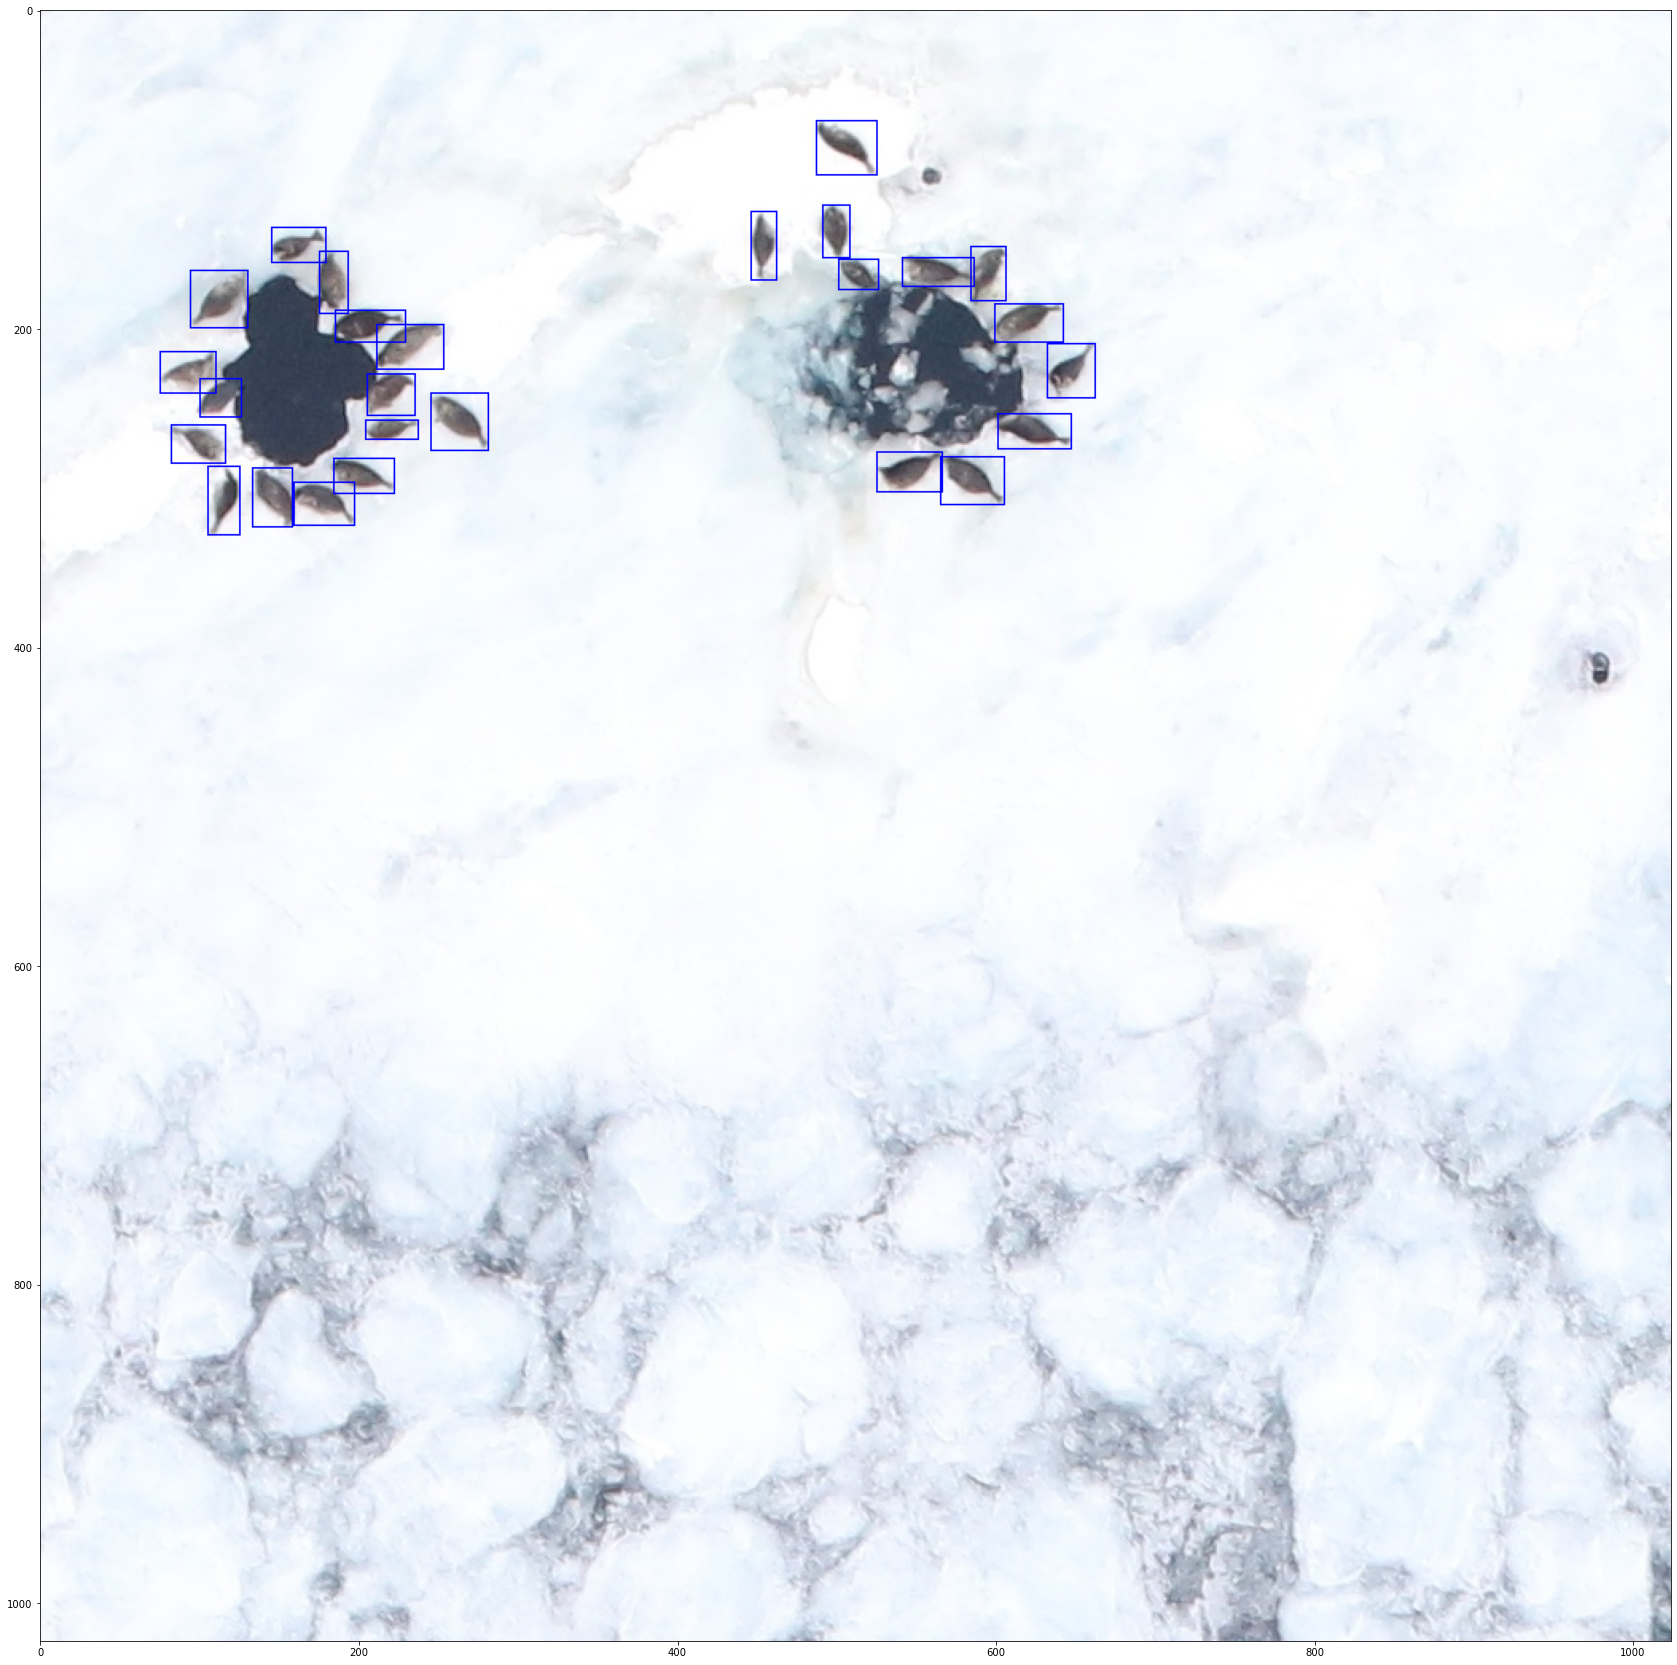

In [492]:
# check if cropping was executed properly

txtfiles = glob.glob('data/cropped/labels/*.txt')
path2txt = txtfiles[219]
path2img = os.path.join('data/cropped/', path2txt.split('/')[-1].split('.')[0] + '.jpg')
img = cv2.imread(path2img)
annotations = np.loadtxt(path2txt)
xyxy = xywh2xyxy(annotations[:, 1::])

# converting to pixel coordinates
xyxy[:, [0, 2]] = xyxy[:, [0, 2]] * ww
xyxy[:, [1, 3]] = xyxy[:, [1, 3]] * hh
xyxy = xyxy.round().astype(int).squeeze()

for c in xyxy:
    xmin, ymin = c[0], c[1]
    xmax, ymax = c[2], c[3]

    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 1)

plt.figure(figsize=(30, 30))
plt.imshow(img[...,::-1])
